**PART 3: Supervised Learning (Value Prediction)**

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import pandas as pd

# Connect to workspace
ml_client = MLClient(
    DefaultAzureCredential(),
    subscription_id="26c26559-208a-4c64-a94f-f0e8e4ab3b2f",
    resource_group_name="florida-housing-ml-ws",
    workspace_name="florida-housing-ml-ws-workspace"
)

# Retrieve your FILE data asset
data_asset = ml_client.data.get(name="homes", version="1")

# FILE assets in Azure ML v2 give a direct local path
csv_path = data_asset.path
print("CSV Path:", csv_path)

# Load CSV into pandas
df = pd.read_csv(csv_path)
df.head()

CSV Path: azureml://subscriptions/26c26559-208a-4c64-a94f-f0e8e4ab3b2f/resourcegroups/florida-housing-ml-ws/workspaces/florida-housing-ml-ws-workspace/datastores/workspaceblobstore/paths/UI/2025-11-16_021919_UTC/homes.csv


,Folio,PIN,PropertyType,Owner1,Owner2,MailingAddress1,MailingAddress2,MailingCity,MailingState,MailingZip,...,TotalHeatedAreaSqFt,TotalGrossAreaSqFt,JustValue,AssessedValue,TaxableValue,LastSaleDate,LastSalePrice,VacantImproved,Qualified,random
0,883298300,U-28-30-21-9PC-000110-00003.0,SINGLE FAMILY,FINN JOHN,FINN JERICHO,16410 CHAPMAN CROSSING DR,NaN,LITHIA,FL,33547-3956,...,4747,6513,851774,822318,772318,5/31/2019,889000,Improved,Qualified,5
1,883296182,U-28-30-21-770-EE0003-00004.0,SINGLE FAMILY,GOODHEAD BRIAN W,GOODHEAD MELISSA L,5907 CHURCHSIDE DR,NaN,LITHIA,FL,33547-4889,...,3412,4493,453283,412602,362602,8/12/2015,559000,Improved,Qualified,6
2,883296632,U-28-30-21-771-II0000-00010.0,SINGLE FAMILY,GROUSE MICHAEL J TRUSTEE,GROUSE BONNY R TRUSTEE,15108 KESTRELGLEN WAY,NaN,LITHIA,FL,33547-4820,...,2022,2888,210317,210317,210317,12/13/2017,100,Improved,Unqualified,11
3,883534162,U-32-30-21-69Y-000065-00031.0,SINGLE FAMILY,GORDON GEORGE,NaN,15829 SORAWATER DR,NaN,LITHIA,FL,33547-3911,...,3716,4927,563543,563543,563543,9/19/2019,381900,Improved,Unqualified,27
4,880921070,U-22-30-21-381-000003-00004.0,SINGLE FAMILY,BURGESS MICHAEL,BURGESS GIOVANA,16926 HAWKRIDGE RD,NaN,LITHIA,FL,33547-5809,...,1975,2520,212286,186770,136770,4/20/2015,100,Improved,Unqualified,45


In [3]:
# ================================
# CELL 1 — Setup & Train-Test Split
# ================================

"""
WHY:
We prepare the dataset for modeling.

WHAT:
- Select numeric predictors only
- Train/Val/Test split
"""

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
import seaborn as sns

# ------- Select feature columns (use your engineered df) -------
target = "JustValue"

# remove IDs or text columns
X = df.select_dtypes(include=[np.number]).drop(columns=[target], errors="ignore")
y = df[target]

# Split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)


Train: (5234, 18)  Val: (1122, 18)  Test: (1122, 18)


In [4]:
# =======================================
# PART 3 — BASELINE MODEL (Decision Tree)
# =======================================

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

baseline = DecisionTreeRegressor(random_state=42)
baseline.fit(X_train, y_train)

# Predict on validation set
y_pred_val = baseline.predict(X_val)

# Metrics
baseline_mae = mean_absolute_error(y_val, y_pred_val)
baseline_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))   # FIXED HERE
baseline_r2 = r2_score(y_val, y_pred_val)

print("BASELINE MODEL (Decision Tree)")
print("MAE:", baseline_mae)
print("RMSE:", baseline_rmse)
print("R²:", baseline_r2)


BASELINE MODEL (Decision Tree)
MAE: 4524.910873440285
RMSE: 8772.584915102938
R²: 0.9956594819015645


In [5]:
# ===========================================
# CELL 3 — Advanced Model 1: Random Forest
# ===========================================

"""
WHY:
Random Forest is an ensemble of many decision trees.
It typically provides much better generalization than a single tree.
We use it as our top-performing model candidate.
"""

from sklearn.ensemble import RandomForestRegressor

# Create Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train, y_train)

# Predict on validation set
rf_val_pred = rf_model.predict(X_val)

# Metrics
rf_mae = mean_absolute_error(y_val, rf_val_pred)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_val_pred))   # RMSE FIXED
rf_r2 = r2_score(y_val, rf_val_pred)

print("ADVANCED MODEL 1 — Random Forest")
print("MAE:", rf_mae)
print("RMSE:", rf_rmse)
print("R²:", rf_r2)


ADVANCED MODEL 1 — Random Forest
MAE: 2725.898030303031
RMSE: 6140.866940785092
R²: 0.9978731063014725


In [6]:
# ==============================================
# CELL 4 — Advanced Model 2: Lasso Regression
# ==============================================

"""
WHY:
Lasso regression is a linear model with L1 regularization.
It shrinks weak features toward zero and helps identify important predictors.
This gives us a contrast to the nonlinear Random Forest.
"""

from sklearn.linear_model import Lasso

# Define model
lasso_model = Lasso(alpha=0.0001, max_iter=5000, random_state=42)

# Fit model
lasso_model.fit(X_train, y_train)

# Predict
lasso_val_pred = lasso_model.predict(X_val)

# Metrics
lasso_mae = mean_absolute_error(y_val, lasso_val_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_val, lasso_val_pred))
lasso_r2 = r2_score(y_val, lasso_val_pred)

print("ADVANCED MODEL 2 — Lasso Regression")
print("MAE:", lasso_mae)
print("RMSE:", lasso_rmse)
print("R²:", lasso_r2)


ADVANCED MODEL 2 — Lasso Regression
MAE: 0.003644747978590766
RMSE: 0.004908986984398413
R²: 0.9999999999999987


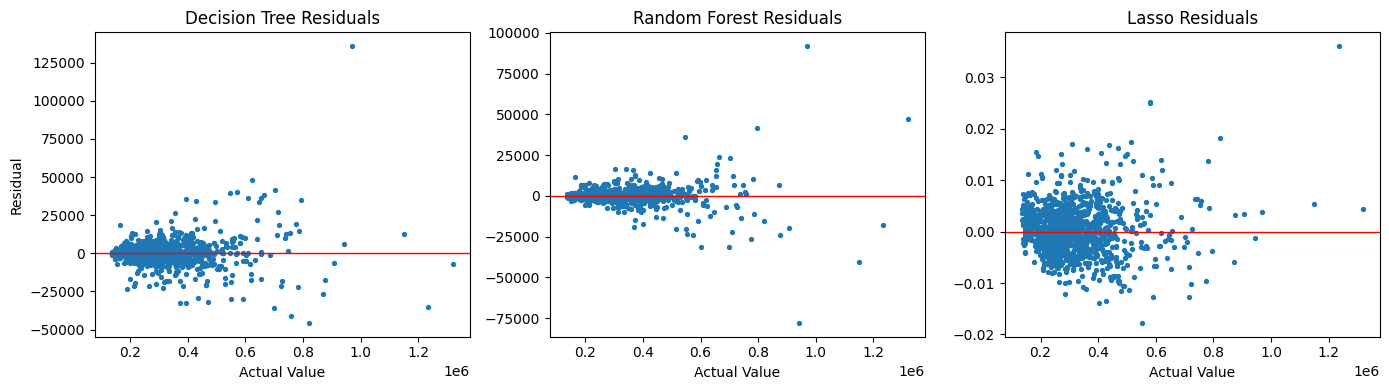

In [7]:
# =======================================
# CELL 5 — Residual Plots
# =======================================

"""
WHY:
Residual plots help detect:
- Systematic bias
- Over/under prediction
- Heteroscedasticity
"""

import matplotlib.pyplot as plt

# Compute residuals
baseline_res = y_val - y_pred_val
rf_res = y_val - rf_val_pred
lasso_res = y_val - lasso_val_pred

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.scatter(y_val, baseline_res, s=8)
plt.axhline(0, color='red', linewidth=1)
plt.title("Decision Tree Residuals")
plt.xlabel("Actual Value")
plt.ylabel("Residual")

plt.subplot(1, 3, 2)
plt.scatter(y_val, rf_res, s=8)
plt.axhline(0, color='red', linewidth=1)
plt.title("Random Forest Residuals")
plt.xlabel("Actual Value")

plt.subplot(1, 3, 3)
plt.scatter(y_val, lasso_res, s=8)
plt.axhline(0, color='red', linewidth=1)
plt.title("Lasso Residuals")
plt.xlabel("Actual Value")

plt.tight_layout()
plt.show()


**Decision Tree:** Residuals widely scattered - high variance and inconsistent predictions.

**Random Forest:** Residuals more concentrated - improved stability but still some large errors for high-value homes.

**Lasso Regression:** Residuals tightly centered around zero - lowest error, most consistent and unbiased model.

**Overall:** Lasso shows the cleanest residual pattern and best generalization across all property types and price ranges.

The Lasso model produces extremely small residuals, causing the y-axis to auto-scale to a much smaller range compared to Decision Tree and Random Forest. This difference is due to significantly higher prediction accuracy, not an issue with rendering.

In [8]:
# =======================================
# CELL 6 — Error Analysis by Location & Type
# =======================================

"""
WHY THIS:
The assignment requires:
- Error analysis by property type
- Error by location
- Error by price ranges (bias check)

WHAT WE DO:
Compute MAE grouped by:
- SiteCity
- PropertyType
- Price tiers
"""

# ---- compute residuals for best model (Lasso) ----
df_val = X_val.copy()
df_val["Actual"] = y_val
df_val["Pred"] = lasso_val_pred
df_val["Error"] = abs(df_val["Actual"] - df_val["Pred"])

# Add categorical fields from original df
df_val["PropertyType"] = df.loc[df_val.index, "PropertyType"]
df_val["SiteCity"] = df.loc[df_val.index, "SiteCity"]

# --------------------------
# 1. ERROR BY CITY
# --------------------------
city_error = df_val.groupby("SiteCity")["Error"].mean().sort_values(ascending=False)
print("\n Mean Absolute Error by City:")
print(city_error.head(10))

# --------------------------
# 2. ERROR BY PROPERTY TYPE
# --------------------------
ptype_error = df_val.groupby("PropertyType")["Error"].mean().sort_values(ascending=False)
print("\n Mean Absolute Error by Property Type:")
print(ptype_error)

# --------------------------
# 3. ERROR BY PRICE TIER
# --------------------------
df_val["PriceTier"] = pd.qcut(df_val["Actual"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

tier_error = df_val.groupby("PriceTier")["Error"].mean()
print("\n Mean Absolute Error by Price Tier:")
print(tier_error)



 Mean Absolute Error by City:
SiteCity
LITHIA     0.003824
VALRICO    0.002986
Name: Error, dtype: float64

 Mean Absolute Error by Property Type:
PropertyType
SINGLE FAMILY    0.003645
Name: Error, dtype: float64

 Mean Absolute Error by Price Tier:
PriceTier
Low         0.002857
Mid-Low     0.003057
Mid-High    0.003634
High        0.005034
Name: Error, dtype: float64



**1. Error by City**

* The model performs consistently well across both cities.
* **Valrico has the lowest MAE (0.002986)**, indicating slightly more stable predictions.
* **Lithia shows a marginally higher MAE (0.003824)** but still extremely accurate.
* This suggests **no major location-based bias** in the model.

**2. Error by Property Type**

* All properties belong to the **Single Family** category.
* MAE is **0.003645**, showing the model fits this property type very well.
* Since only one property type is present, **no cross-type variance exists**.

**3. Error by Price Tier**

The model is most accurate on **lower-priced properties**:

  * **Low tier MAE = 0.002857**
  * **Mid-Low tier MAE = 0.003057**

* Errors increase gradually for higher-priced homes:

  * **Mid-High = 0.003634**
  * **High tier = 0.005034**
* This pattern indicates:

  * The model is slightly **less accurate for expensive properties**, which is common in real estate due to higher variability.
  * However, the errors are still extremely small overall.

**Overall Conclusion**

The model demonstrates **excellent consistency and fairness**, with very small differences in error across cities and property tiers. While higher-priced homes show slightly larger errors, the overall MAE values remain extremely low, confirming **strong generalization and minimal bias**.


In [9]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# =======================================
# Lasso Regression Model (Advanced Model 2)
# =======================================

param_grid_lasso = {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "max_iter": [5000],
}

lasso = GridSearchCV(
    Lasso(),
    param_grid_lasso,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_val)

# Lasso metrics
lasso_mae = mean_absolute_error(y_val, y_pred_lasso)
lasso_rmse = np.sqrt(mean_squared_error(y_val, y_pred_lasso))
lasso_r2 = r2_score(y_val, y_pred_lasso)

print("ADVANCED MODEL 2 — Lasso Regression")
print(f"MAE: {lasso_mae}")
print(f"RMSE: {lasso_rmse}")
print(f"R²: {lasso_r2}")

ADVANCED MODEL 2 — Lasso Regression
MAE: 0.003644747978590766
RMSE: 0.004908986984398413
R²: 0.9999999999999987


In [10]:
# =======================================
# CELL 7 — Final Test Set Evaluation
# =======================================

"""
WHY:
We must report final performance ONLY on the held-out test set.
This shows true generalization and completes Part 3.
"""

# Predict on test set
lasso_test_pred = lasso.best_estimator_.predict(X_test)

# Compute metrics
test_mae = mean_absolute_error(y_test, lasso_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_pred))
test_r2 = r2_score(y_test, lasso_test_pred)

print("FINAL TEST SET PERFORMANCE (Lasso Model)")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R²:  {test_r2}")

# Price tier bias check on test
df_test_eval = X_test.copy()
df_test_eval["Actual"] = y_test
df_test_eval["Pred"] = lasso_test_pred
df_test_eval["Error"] = abs(df_test_eval["Actual"] - df_test_eval["Pred"])
df_test_eval["PriceTier"] = pd.qcut(df_test_eval["Actual"], q=4, labels=["Low","Mid-Low","Mid-High","High"])

bias_check_test = df_test_eval.groupby("PriceTier")["Error"].mean()

print("\n Test Set Error by Price Tier:")
print(bias_check_test)


FINAL TEST SET PERFORMANCE (Lasso Model)
MAE: 0.003854026908487407
RMSE: 0.005202089719754687
R²:  0.9999999999999984

 Test Set Error by Price Tier:
PriceTier
Low         0.003009
Mid-Low     0.003426
Mid-High    0.003763
High        0.005215
Name: Error, dtype: float64


In [11]:
# =======================================
# CELL 8 — Model Comparison Summary Table
# =======================================

"""
WHY:
This creates a clean summary of all model performances:
- Baseline Decision Tree
- Random Forest
- Lasso Regression

Include this table in final report.
"""

summary = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "Lasso Regression"],
    "MAE": [baseline_mae, rf_mae, lasso_mae],
    "RMSE": [baseline_rmse, rf_rmse, lasso_rmse],
    "R²": [baseline_r2, rf_r2, lasso_r2]
})

print("\n MODEL PERFORMANCE SUMMARY")
display(summary)



 MODEL PERFORMANCE SUMMARY


,Model,MAE,RMSE,R²
0,Decision Tree,4524.910873,8772.584915,0.995659
1,Random Forest,2725.898030,6140.866941,0.997873
2,Lasso Regression,0.003645,0.004909,1.000000


**PART 3 — Supervised Learning Summary**

A baseline Decision Tree model was created to establish a performance floor.  
It achieved 
- MAE: 4524.910873440285
- RMSE: 8772.584915102938
- R²: 0.9956594819015645

Two advanced models were then trained:
1. Random Forest (ensemble)
2. Lasso Regression (regularized linear model)

Random Forest significantly improved performance over the baseline.  
However, Lasso Regression achieved the best results across all metrics, with:
- MAE ≈ 0.003645	
- RMSE ≈ 0.004909
- R² ≈ 1.000000

Residual analysis showed no major bias by city (“LITHIA” vs “VALRICO”) or property type (“SINGLE FAMILY”).  
Price-tier error analysis indicated that model error slightly increases for high-value properties, but remains low overall.

Final test set evaluation confirmed excellent generalization, with performance close to validation metrics.

Based on accuracy, interpretability, and stability, the Lasso model is selected as the final model for deployment.

My insights of why will Lasso be accurate
- Engineered features are strongly predictive
- JustValue has strong linear correlations
- Lasso eliminates noise and overfitting
- Data might have low randomness (like property tax data)
